# How To Play Blackjack, In 4 Easy Steps
When it comes to blackjack strategy, there are loads of rules to learn. But the basic guide of how to play blackjack is simple: 
* Your goal in blackjack is to beat the dealer’s hand without going over 21. 
* You’ll receive 2 cards at the beginning of each round, and you’ll add up the values of these cards. 
    * Cards 2-10 have face value 
    * King, Queen, Jack are worth 10
    * Aces are either a 1 or an 11 — it’s up to you to decide.
* The dealer also draws two cards. 
* The aim of the game is to beat his hand (have a higher hand) without going over 21.
* If you would like the dealer to deal you another card, you tell him “hit”
* If you do not want to be dealt another card, you “stand”
* “Busting” is when the sum of your hand is over 21. 
* The winner of the round is whoever has the highest hand without going bust. 

# Example 5.3 Monte Carlo Control
Reinforcement Learning: An Introduction (second edition) Richard S. Sutton and Andrew G. Barto

#### Monte Carlo ES (Exploring Starts), for estimating π ≈ π∗
```
Initialize, for all s ∈ S, a ∈ A(s):
    Q(s, a) ← arbitrary
    π(s) ← arbitrary
    Returns(s, a) ← empty list

Repeat forever:
    Choose S 0 ∈ S and A 0 ∈ A(S 0 ) s.t. all pairs have probability > 0
    Generate an episode starting from S 0 , A 0 , following π
    For each pair s, a appearing in the episode:
        G ← the return that follows the first occurrence of s, a
        Append G to Returns(s, a)
        Q(s, a) ← average(Returns(s, a))

    For each s in the episode:
        π(s) ← argmax a Q(s, a)
```        

Example 5.3: Solving Blackjack It is straightforward to apply Monte Carlo ES to blackjack.
Since the episodes are all simulated games, it is easy to arrange for exploring starts that include all
possibilities. In this case one simply picks the dealer’s cards, the player’s sum, and whether or not the
player has a usable ace, all at random with equal probability. As the initial policy we use the policy
evaluated in the previous blackjack example,that which sticks only on 20 or 21. The initial action-value
function can be zero for all state–action pairs.

In [1]:
import random
import numpy as np
import itertools
from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def getCard():
    c = random.randint(1,13)
    if c>10: c = 10
    return c

def getAction(curr_sum):
    a = 'hit'
    if curr_sum >= 20: a = 'stick'
    return a

def getDealerAction(dealer_curr_sum):
    a = 'hit'
    if dealer_curr_sum >= 17: a = 'stick'
    return a

#initialize
state_curr_sum_list = np.arange(12,22)
state_dealer_showing_list = np.arange(1,11)
state_usable_ace_list = [0,1]
action_list = ['hit','stick']

qsa_values = {}
sa_returns = {}
pi = {}

for s in itertools.product(state_curr_sum_list,state_dealer_showing_list,state_usable_ace_list):
    pi[s] = getAction(s[0])
    for a in action_list:
        qsa_values[(s,a)] = 0
        sa_returns[(s,a)] = []
        
loops = 1_000_000

for k in range(loops):
    episode = []
    curr_sum = random.sample(list(state_curr_sum_list),1)[0]
    dealer_showing = random.sample(list(state_dealer_showing_list),1)[0]
    usable_ace = random.sample(list(state_usable_ace_list),1)[0]
    a = random.sample(action_list,1)[0]
    
    dealer_c1 = dealer_showing
    dealer_c2 = getCard()
    episode.append(((curr_sum,dealer_showing,usable_ace),a))
    burst = False
    while a == 'hit' and not burst:
        c = getCard()        
        curr_sum = curr_sum + c
        if curr_sum > 21 and usable_ace == 0:
            burst = True
        elif curr_sum > 21 and usable_ace == 1:
            usable_ace = 0
            curr_sum = curr_sum - 10
            a = getAction(curr_sum)                          
        else:
            a = getAction(curr_sum)
        if not burst:
            episode.append(((curr_sum,dealer_showing,usable_ace),a))        
    r = 0
    if burst:
        r = -1
    else:
        #dealer's turn
        dealer_curr_sum = dealer_c1 + dealer_c2
        dealer_usable_ace = 0
        if dealer_c1==1 or dealer_c2==1:
            dealer_curr_sum = dealer_curr_sum + 10
            dealer_usable_ace = 1
        if dealer_curr_sum >= 17:
            if dealer_curr_sum > curr_sum:
                r = -1
            elif dealer_curr_sum == curr_sum:
                r = 0
            else:
                r = 1
        else:
            dealer_a = 'hit'
            dealer_burst = False
            while dealer_a == 'hit' and not dealer_burst:
                dealer_c = getCard()                
                dealer_curr_sum = dealer_curr_sum + dealer_c
                if dealer_curr_sum > 21 and dealer_usable_ace == 0:
                    dealer_burst = True
                elif dealer_curr_sum > 21 and dealer_usable_ace == 1:
                    dealer_usable_ace = 0
                    dealer_curr_sum = dealer_curr_sum - 10
                    dealer_a = getDealerAction(dealer_curr_sum)                
                elif dealer_curr_sum < 12:                    
                    if dealer_c == 1:
                        dealer_curr_sum = dealer_curr_sum + 10
                        dealer_usable_ace = 1
                        dealer_a = getDealerAction(dealer_curr_sum)
                    else:
                        dealer_a = 'hit'   
                else:
                    dealer_a = getDealerAction(dealer_curr_sum)                
            if dealer_burst:
                r = 1
            elif dealer_curr_sum < curr_sum:
                r = 1
            elif dealer_curr_sum == curr_sum:
                r =0
            else:
                r = -1
    #print "user:{}".format(user_cards)
    #print "user sum:{} dealer_showing:{} usable_ace: {}".format(curr_sum,dealer_showing,usable_ace)            
    #print "dealer:{}".format(dealer_cards)
    #print "dealer sum:{} dealer_usable_ace: {}".format(dealer_curr_sum,dealer_usable_ace)
    #print "reward: {}".format(r)
    for (s,a) in episode:
        sa_returns[(s,a)].append(r)
        qsa_values[(s,a)] = np.mean(sa_returns[(s,a)])
    for (s,a) in episode:
        maxq = -1
        for aa in action_list:
            if maxq < qsa_values[(s,aa)]:
                maxq = qsa_values[(s,aa)]
                pi[s] = aa

for qsa in qsa_values: print(qsa)
print()
for p in pi: print(p)

((12, 1, 0), 'hit')
((12, 1, 0), 'stick')
((12, 1, 1), 'hit')
((12, 1, 1), 'stick')
((12, 2, 0), 'hit')
((12, 2, 0), 'stick')
((12, 2, 1), 'hit')
((12, 2, 1), 'stick')
((12, 3, 0), 'hit')
((12, 3, 0), 'stick')
((12, 3, 1), 'hit')
((12, 3, 1), 'stick')
((12, 4, 0), 'hit')
((12, 4, 0), 'stick')
((12, 4, 1), 'hit')
((12, 4, 1), 'stick')
((12, 5, 0), 'hit')
((12, 5, 0), 'stick')
((12, 5, 1), 'hit')
((12, 5, 1), 'stick')
((12, 6, 0), 'hit')
((12, 6, 0), 'stick')
((12, 6, 1), 'hit')
((12, 6, 1), 'stick')
((12, 7, 0), 'hit')
((12, 7, 0), 'stick')
((12, 7, 1), 'hit')
((12, 7, 1), 'stick')
((12, 8, 0), 'hit')
((12, 8, 0), 'stick')
((12, 8, 1), 'hit')
((12, 8, 1), 'stick')
((12, 9, 0), 'hit')
((12, 9, 0), 'stick')
((12, 9, 1), 'hit')
((12, 9, 1), 'stick')
((12, 10, 0), 'hit')
((12, 10, 0), 'stick')
((12, 10, 1), 'hit')
((12, 10, 1), 'stick')
((13, 1, 0), 'hit')
((13, 1, 0), 'stick')
((13, 1, 1), 'hit')
((13, 1, 1), 'stick')
((13, 2, 0), 'hit')
((13, 2, 0), 'stick')
((13, 2, 1), 'hit')
((13, 2, 1

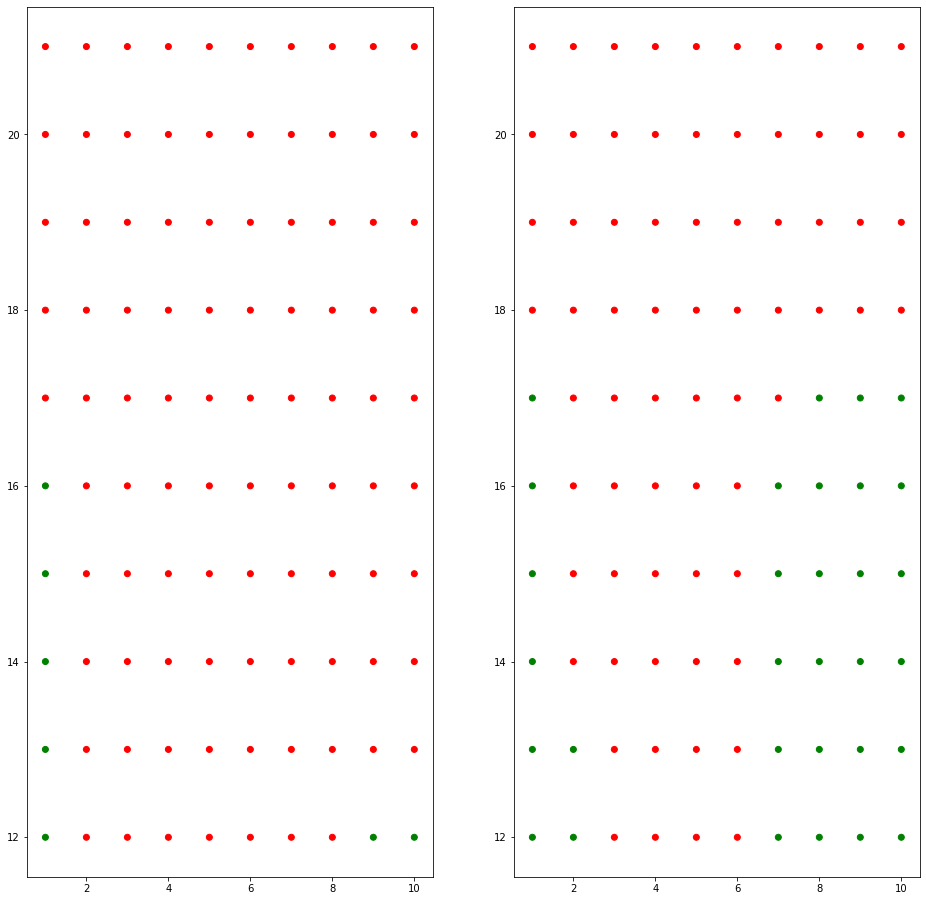

In [2]:
# Plot strategy
X = []
Y = []
C1 = []
C2 = []
for i in state_dealer_showing_list:
    for j in state_curr_sum_list:
        X.append(i)
        Y.append(j)
        if pi[(j,i,0)] == 'hit':
            C1.append('g')
        else:
            C1.append('r')
        if pi[(j,i,1)] == 'hit':
            C2.append('g')
        else:
            C2.append('r')
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(121)
ax1.scatter(X,Y,c = C1)
ax1.plot()
ax2 = fig.add_subplot(122)
ax2.scatter(X,Y,c = C2)
ax2.plot()
plt.show()